In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Feature extraction

In [2]:
import glob
import os
import numpy as np

from PIL import Image, ImageFile
from omegaconf import OmegaConf

from config.init import create_baseconfig_from_checkpoint
from model.lgffem import LGFFEM

from tqdm import tqdm

import umap

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [3]:
import torch
from torchvision.transforms import v2

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Create model from checkpoint

In [4]:
path_checkpoint = os.path.join('/thesis/checkpoint/BASE/BASE-EMB-KIMIA-11_convnextv2-02_neck_512_3-00_head_A-epoch499.pth')
checkpoint = torch.load(path_checkpoint)

In [5]:
base_config = create_baseconfig_from_checkpoint(checkpoint)

embedder = LGFFEM(base_config).eval().to(device)
match_n = embedder.neck.load_state_dict(checkpoint['model_neck_state_dict'], strict = False)
print('[++] Loaded neck weights.', match_n)
match_h = embedder.head.load_state_dict(checkpoint['model_head_state_dict'], strict = False)
print('[++] Loaded head weights.', match_h)

[++] Loaded neck weights. <All keys matched successfully>
[++] Loaded head weights. <All keys matched successfully>


In [6]:
img_transforms = v2.Compose([
                            v2.ToImage(),
                            v2.Resize(size=(224, 224)),
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                          ])

## Get embeddings from Kimia Test imgs

In [7]:
from pathlib import Path
from natsort import natsorted
import itertools

PATH_TEST = '/thesis/classical/test-patches-kimia/'

dict_img = {}
for i in range(0,24):
    path_i = f'/thesis/classical/test-patches-kimia/s{i}'
    dict_img[f's{i}'] = natsorted([path for path in Path(path_i).rglob('*.jpg')], key=str)
    
img_l = list(itertools.chain.from_iterable(dict_img.values()))

KIMIA_CLASSES_IDX = dict([(f's{i}',i) for i in range(24)])
classes = [KIMIA_CLASSES_IDX[path.name.split('_')[0]] for path in img_l]

In [8]:
def pil_loader(path):
    # to avoid crashing for truncated (corrupted images)
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    # open path as file to avoid ResourceWarning 
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [9]:
im_embs_l = []
for i in tqdm(img_l):
    im = pil_loader(i)
    im = img_transforms(im).unsqueeze(0).to(device)
    im_embs_l.append(embedder(im).detach().cpu().numpy())

X = np.stack(im_embs_l, axis=0).squeeze(1)

100%|██████████| 1325/1325 [00:38<00:00, 34.19it/s]


In [10]:
X.shape

(1325, 2048)

## Projection 2D of the embbedings

In [11]:
reducer = umap.UMAP(random_state=42)
reducer.fit(X)

UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [12]:
proj_embedding = reducer.transform(X)

# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(proj_embedding == reducer.embedding_))
proj_embedding.shape

(1325, 2)

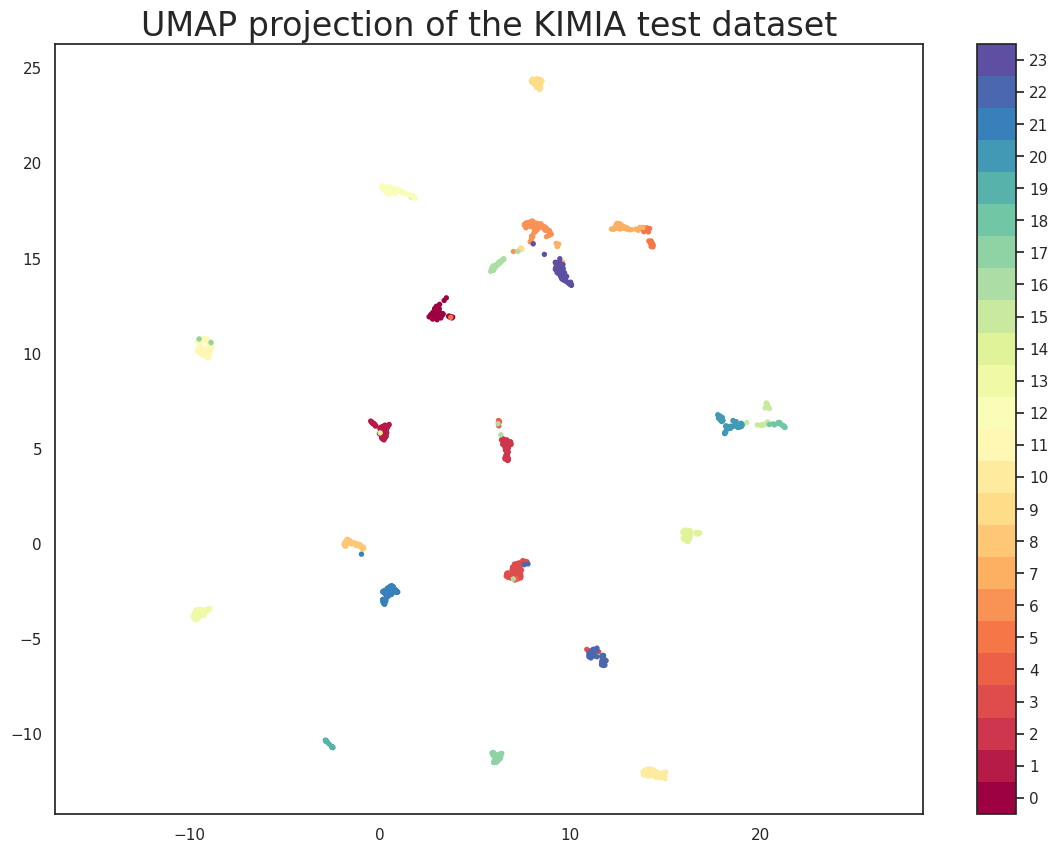

In [13]:
plt.scatter(proj_embedding[:, 0], proj_embedding[:, 1], c=classes, cmap='Spectral', s=8)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(25)-0.5).set_ticks(np.arange(24))
plt.title('UMAP projection of the KIMIA test dataset', fontsize=24);